<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/prefussion_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoMM for Image + Text + Tabular - Quick Start

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/multimodal_prediction/beginner_multimodal.ipynb)



AutoMM is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format
and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

In [ ]:
!pip install -U -qqq pip --upgrade
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install autogluon
!pip install typing_extensions==4.8.0 --force-reinstall

In [ ]:
# OSError: /usr/local/lib/python3.10/dist-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZN3c104cuda9SetDeviceEi
!pip uninstall torchaudio -y

Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121


In [5]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


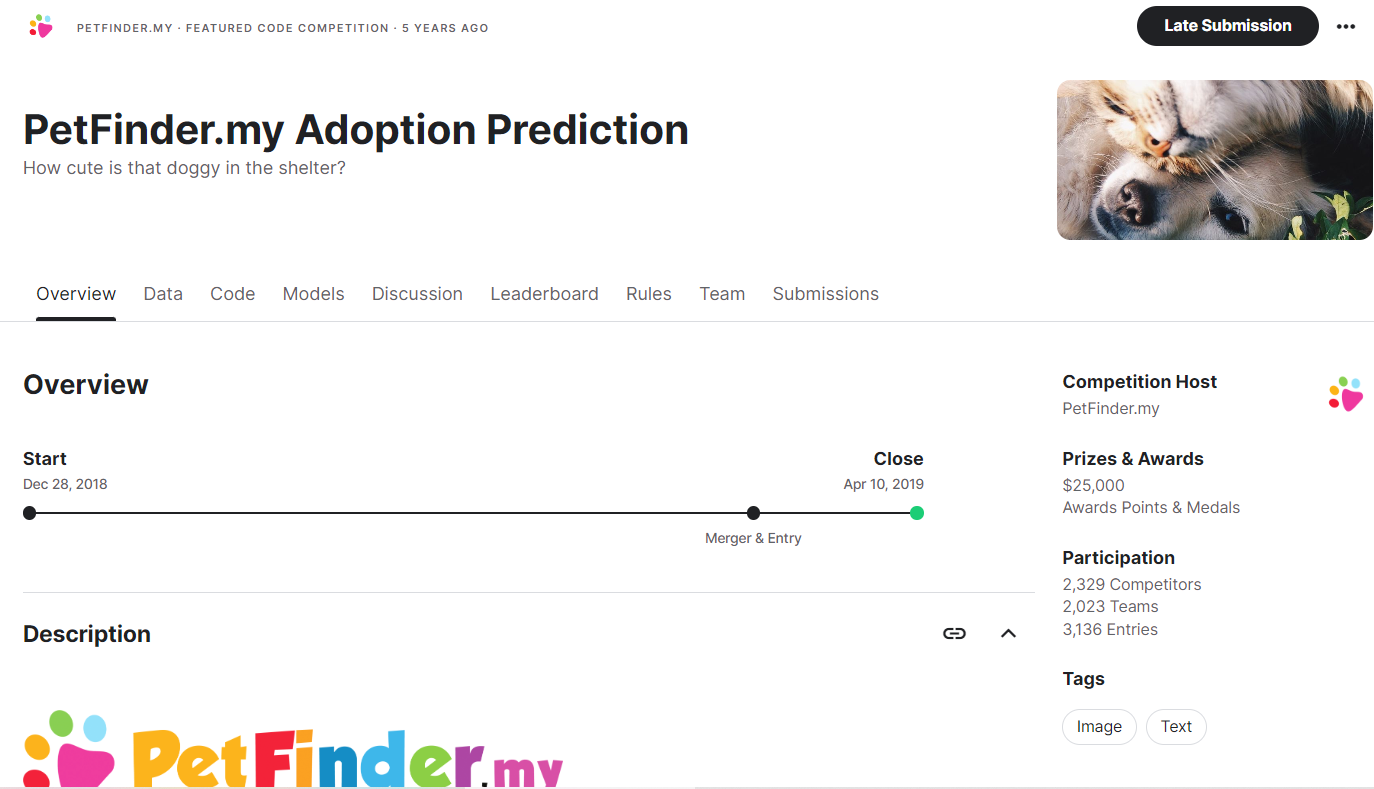

In [ ]:
# 讀取檔案

download_dir = './ag_automm_tutorial'
# !wget https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip
!wget https://github.com/zhe0/prac/blob/main/petfinder_for_tutorial.zip
!unzip /content/petfinder_for_tutorial.zip

# zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
# from autogluon.core.utils.loaders import load_zip
# load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, we will load the CSV files.

In [3]:
# dataset_path = download_dir + '/petfinder_for_tutorial'
dataset_path='/content/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

We need to expand the image paths to load them in training.

In [6]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

In [7]:
example_row = train_data.iloc[0]
example_row

Type                                                             2
Name                                                 Yumi Hamasaki
Age                                                              4
Breed1                                                         292
Breed2                                                         265
Gender                                                           2
Color1                                                           1
Color2                                                           5
Color3                                                           7
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         3
Sterilized                                                       2
Health                                                        

In [8]:
example_row['Description']

"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

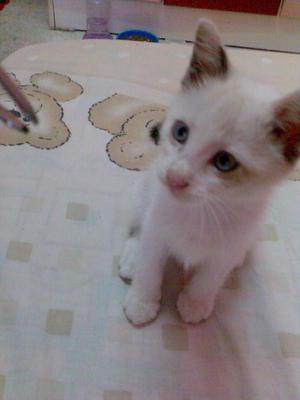

In [9]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

In [ ]:
# cpu ver
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col)
predictor.fit(
    train_data=train_data,
    time_limit=120, # seconds
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240126_075325"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
Pytorch Version:    2.0.1+cu118
CUDA Version:       CUDA is not available
Memory Avail:       10.93 GB / 12.67 GB (86.2%)
Disk Space Avail:   69.45 GB / 107.72 GB (64.5%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have ins

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/395M [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 207 M 
1 | validation_metric | BinaryAUROC         | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
207 M     Trainable params
0         Non-trainable params
207 M     Total params
828.117   Total estimated model params size (MB)
INFO: 
  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | Multimodal

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO: Time limit reached. Elapsed time is 0:02:13. Signaling Trainer to stop.
INFO: Time limit reached. Elapsed time is 0:02:13. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240126_075325")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
# GPU ver
# from autogluon.multimodal import MultiModalPredictor
# if torch.cuda.is_available():
#   # Get the number of available GPU
#   predictor_gpu = MultiModalPredictor(label=label_col)
#   predictor_gpu.fit(
#       train_data=train_data,
#       time_limit=120, # seconds
#   )

Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [ ]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.6516000000000001}

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [ ]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: 0it [00:00, ?it/s]

8     0
70    0
82    0
28    0
63    1
Name: AdoptionSpeed, dtype: int64

For classification tasks, we can get the probabilities of all classes.

In [ ]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: 0it [00:00, ?it/s]

,0,1
8,0.513770,0.486230
70,0.774978,0.225022
82,0.891982,0.108018
28,0.965650,0.034350
63,0.311051,0.688949


Note that calling `.predict_proba()` on one regression task will throw an exception.


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [ ]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: 0it [00:00, ?it/s]

(100, 128)

## Save and Load
It is also convenient to save a predictor and re-load it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).